#### Installs

In [ ]:
!pip -q install -U datasets transformers accelerate evaluate sentence-transformers matplotlib

In [ ]:
!pip -q uninstall -y numpy scipy scikit-learn pandas
!pip -q install --no-cache-dir "numpy==2.0.2" "scipy==1.14.1" "scikit-learn==1.6.1" "pandas==2.2.2"

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
from datetime import datetime

PROJECT_ROOT = "/content/drive/MyDrive/DL_project"
RUN_NAME = datetime.now().strftime("qqp_run_%Y%m%d_%H%M%S")
RUN_DIR = os.path.join(PROJECT_ROOT, "runs", RUN_NAME)

os.makedirs(RUN_DIR, exist_ok=True)
print("RUN_DIR:", RUN_DIR)

Mounted at /content/drive
RUN_DIR: /content/drive/MyDrive/DL_project/runs/qqp_run_20260114_221955


In [ ]:
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay
)

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

SEED = 42

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    import os
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(SEED)
print("transformers:", transformers.__version__)

transformers: 4.57.5


#### Dataset overview

In [ ]:
raw = load_dataset("glue", "qqp")

def clean_example(ex):
    q1 = ex["question1"] if ex["question1"] is not None else ""
    q2 = ex["question2"] if ex["question2"] is not None else ""
    ex["question1"] = q1.strip()
    ex["question2"] = q2.strip()
    return ex

def non_empty(ex):
    return len(ex["question1"]) > 0 and len(ex["question2"]) > 0

qqp_train = raw["train"].map(clean_example).filter(non_empty)
qqp_train

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

qqp/train-00000-of-00001.parquet:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

qqp/validation-00000-of-00001.parquet:   0%|          | 0.00/3.73M [00:00<?, ?B/s]

qqp/test-00000-of-00001.parquet:   0%|          | 0.00/36.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/363846 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/40430 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/390965 [00:00<?, ? examples/s]

Map:   0%|          | 0/363846 [00:00<?, ? examples/s]

Filter:   0%|          | 0/363846 [00:00<?, ? examples/s]

Dataset({
    features: ['question1', 'question2', 'label', 'idx'],
    num_rows: 363846
})

In [ ]:
df = qqp_train.to_pandas()[["question1", "question2", "label"]].copy()

train_df, temp_df = train_test_split(
    df, test_size=0.20, random_state=SEED, stratify=df["label"]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=SEED, stratify=temp_df["label"]
)

splits = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
})

print({k: len(v) for k, v in splits.items()})
splits

{'train': 291076, 'validation': 36385, 'test': 36385}


DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label'],
        num_rows: 291076
    })
    validation: Dataset({
        features: ['question1', 'question2', 'label'],
        num_rows: 36385
    })
    test: Dataset({
        features: ['question1', 'question2', 'label'],
        num_rows: 36385
    })
})

        split  non_dup(0)  dup(1)
0       train      183574  107502
1  validation       22947   13438
2        test       22947   13438


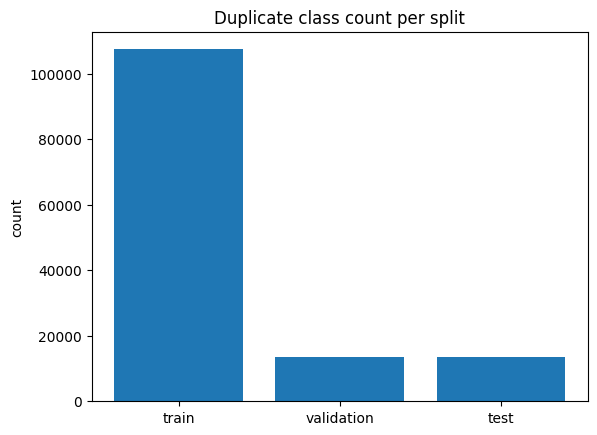

Saved: /content/drive/MyDrive/DL_project/runs/qqp_run_20260114_221955/eda_class_balance.csv


In [ ]:
def class_counts(ds):
    s = pd.Series(ds["label"]).value_counts().sort_index()
    return int(s.get(0,0)), int(s.get(1,0))

rows = []
for split_name in ["train", "validation", "test"]:
    n0, n1 = class_counts(splits[split_name])
    rows.append({"split": split_name, "non_dup(0)": n0, "dup(1)": n1})

eda_balance = pd.DataFrame(rows)
print(eda_balance)

plt.figure()
plt.bar(eda_balance["split"], eda_balance["dup(1)"])
plt.title("Duplicate class count per split")
plt.ylabel("count")
plt.show()

balance_path = os.path.join(RUN_DIR, "eda_class_balance.csv")
eda_balance.to_csv(balance_path, index=False)
print("Saved:", balance_path)

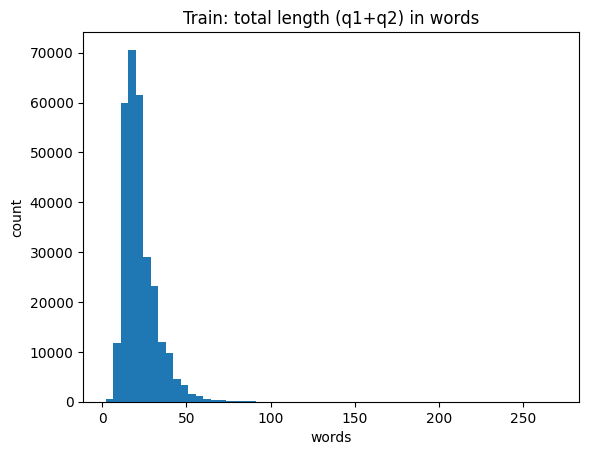

Saved: /content/drive/MyDrive/DL_project/runs/qqp_run_20260114_221955/eda_len_hist.png
Saved: /content/drive/MyDrive/DL_project/runs/qqp_run_20260114_221955/eda_len_stats.csv


In [ ]:
def add_len_cols(df_):
    df_ = df_.copy()
    df_["len_q1"] = df_["question1"].str.split().apply(len)
    df_["len_q2"] = df_["question2"].str.split().apply(len)
    df_["len_sum"] = df_["len_q1"] + df_["len_q2"]
    return df_

eda_train = add_len_cols(train_df)

plt.figure()
plt.hist(eda_train["len_sum"], bins=60)
plt.title("Train: total length (q1+q2) in words")
plt.xlabel("words")
plt.ylabel("count")
len_plot_path = os.path.join(RUN_DIR, "eda_len_hist.png")
plt.savefig(len_plot_path, bbox_inches="tight")
plt.show()
print("Saved:", len_plot_path)

len_stats_path = os.path.join(RUN_DIR, "eda_len_stats.csv")
eda_train[["len_q1","len_q2","len_sum"]].describe().to_csv(len_stats_path)
print("Saved:", len_stats_path)

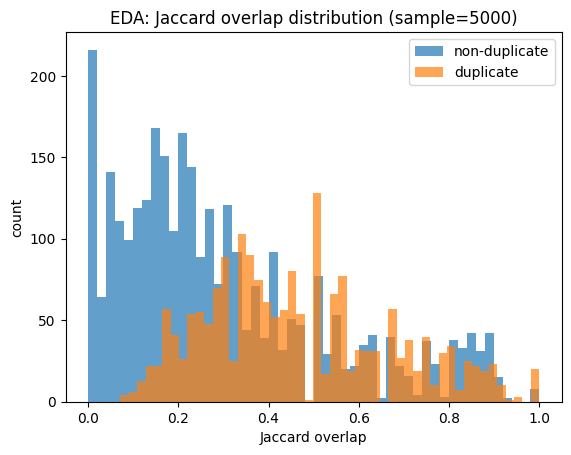

Saved: /content/drive/MyDrive/DL_project/runs/qqp_run_20260114_221955/eda_jaccard_hist.png


In [ ]:
def jaccard_overlap(q1, q2):
    s1 = set(re.findall(r"\w+", q1.lower()))
    s2 = set(re.findall(r"\w+", q2.lower()))
    if not s1 and not s2:
        return 0.0
    return len(s1 & s2) / max(1, len(s1 | s2))

sample = train_df.sample(5000, random_state=SEED).copy()
sample["jaccard"] = [jaccard_overlap(a,b) for a,b in zip(sample["question1"], sample["question2"])]

plt.figure()
plt.hist(sample[sample["label"]==0]["jaccard"], bins=50, alpha=0.7, label="non-duplicate")
plt.hist(sample[sample["label"]==1]["jaccard"], bins=50, alpha=0.7, label="duplicate")
plt.title("EDA: Jaccard overlap distribution (sample=5000)")
plt.xlabel("Jaccard overlap")
plt.ylabel("count")
plt.legend()

jacc_plot_path = os.path.join(RUN_DIR, "eda_jaccard_hist.png")
plt.savefig(jacc_plot_path, bbox_inches="tight")
plt.show()
print("Saved:", jacc_plot_path)

#### Metrics and confusion matrix

In [ ]:
def metrics_dict(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
    }

def show_and_save_cm(y_true, y_pred, title, out_path):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(values_format="d")
    plt.title(title)
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()
    print("Saved:", out_path)

### Method 1: SentenceTransformer

#### Encode + tune threshold on val

In [ ]:
from sentence_transformers import SentenceTransformer

st_model_name = "sentence-transformers/all-MiniLM-L6-v2"
st_model = SentenceTransformer(st_model_name)

def get_embeddings(model, texts, batch_size=256):
    return model.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True
    )

val_q1 = splits["validation"]["question1"]
val_q2 = splits["validation"]["question2"]
val_y  = np.array(splits["validation"]["label"])

val_emb1 = get_embeddings(st_model, val_q1)
val_emb2 = get_embeddings(st_model, val_q2)

# embeddings are normalized -> cosine = dot product
val_sim = np.sum(val_emb1 * val_emb2, axis=1)

def tune_threshold(sim, y_true):
    thresholds = np.linspace(-0.1, 0.95, 106)
    best_thr, best_f1 = None, -1
    for thr in thresholds:
        pred = (sim >= thr).astype(int)
        f1 = f1_score(y_true, pred)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = float(thr)
    return best_thr, best_f1

best_thr, best_f1 = tune_threshold(val_sim, val_y)
print("Best threshold (val):", best_thr, "Best F1:", best_f1)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

Best threshold (val): 0.74 Best F1: 0.7417799752781211


#### SentenceTransformer: evaluate on test

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

ST TEST metrics: {'accuracy': 0.7633090559296414, 'f1': 0.7343615052436767, 'precision': 0.6271204298809399, 'recall': 0.8858461080517934}


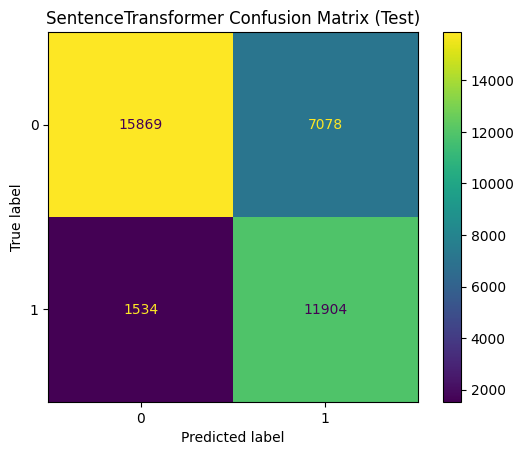

Saved: /content/drive/MyDrive/DL_project/runs/qqp_run_20260114_221955/cm_st_test.png


In [ ]:
test_q1 = splits["test"]["question1"]
test_q2 = splits["test"]["question2"]
test_y  = np.array(splits["test"]["label"])

test_emb1 = get_embeddings(st_model, test_q1)
test_emb2 = get_embeddings(st_model, test_q2)
test_sim = np.sum(test_emb1 * test_emb2, axis=1)

st_test_pred = (test_sim >= best_thr).astype(int)

st_metrics = metrics_dict(test_y, st_test_pred)
print("ST TEST metrics:", st_metrics)

st_cm_path = os.path.join(RUN_DIR, "cm_st_test.png")
show_and_save_cm(test_y, st_test_pred, "SentenceTransformer Confusion Matrix (Test)", st_cm_path)

pd.DataFrame([{"model":"SentenceTransformer", **st_metrics}]).to_csv(
    os.path.join(RUN_DIR, "st_test_metrics.csv"), index=False
)

#### Method 2: BERT classifier

In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_batch(batch):
    return tokenizer(
        batch["question1"],
        batch["question2"],
        truncation=True,
        max_length=128
    )

train_tok = splits["train"].map(tokenize_batch, batched=True)
val_tok   = splits["validation"].map(tokenize_batch, batched=True)
test_tok  = splits["test"].map(tokenize_batch, batched=True)

cols = ["input_ids", "attention_mask", "label"]
train_tok.set_format(type="torch", columns=cols)
val_tok.set_format(type="torch", columns=cols)
test_tok.set_format(type="torch", columns=cols)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/291076 [00:00<?, ? examples/s]

Map:   0%|          | 0/36385 [00:00<?, ? examples/s]

Map:   0%|          | 0/36385 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

def hf_compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return metrics_dict(labels, preds)

training_args = TrainingArguments(
    output_dir=os.path.join(RUN_DIR, "bert_checkpoints"),
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.05,
    label_smoothing_factor=0.1,
    logging_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=data_collator,
    compute_metrics=hf_compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

train_output = trainer.train()
train_output

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.378000,0.368105,0.893033,0.859525,0.834525,0.886069
2,0.340700,0.364828,0.902157,0.869855,0.854915,0.885325
3,0.291900,0.385187,0.906637,0.875800,0.860850,0.891278
4,0.253600,0.398820,0.906995,0.876856,0.857997,0.896562


TrainOutput(global_step=72772, training_loss=0.32181194724569034, metrics={'train_runtime': 13883.8989, 'train_samples_per_second': 83.86, 'train_steps_per_second': 5.241, 'total_flos': 3.580835191249896e+16, 'train_loss': 0.32181194724569034, 'epoch': 4.0})

BERT TEST metrics: {'accuracy': 0.9066098667033118, 'f1': 0.8765710134398838, 'precision': 0.8562304853817769, 'recall': 0.8979014734335466}


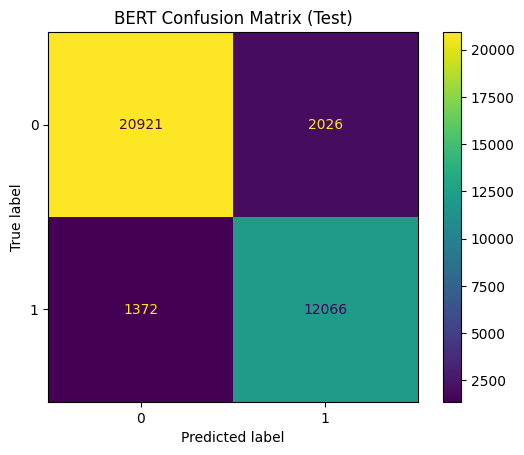

Saved: /content/drive/MyDrive/DL_project/runs/qqp_run_20260114_221955/cm_bert_test.png


In [ ]:
test_out = trainer.predict(test_tok)
test_pred = np.argmax(test_out.predictions, axis=1)
test_y = np.array(splits["test"]["label"])

bert_metrics = metrics_dict(test_y, test_pred)
print("BERT TEST metrics:", bert_metrics)

bert_cm_path = os.path.join(RUN_DIR, "cm_bert_test.png")
show_and_save_cm(test_y, test_pred, "BERT Confusion Matrix (Test)", bert_cm_path)

pd.DataFrame([{"model":"BERT", **bert_metrics}]).to_csv(
    os.path.join(RUN_DIR, "bert_test_metrics.csv"), index=False
)

In [ ]:
FINAL_DIR = os.path.join(RUN_DIR, "qqp_bert_final")
trainer.save_model(FINAL_DIR)
tokenizer.save_pretrained(FINAL_DIR)

print("Saved final model to:", FINAL_DIR)

Saved final model to: /content/drive/MyDrive/DL_project/runs/qqp_run_20260114_221955/qqp_bert_final


In [ ]:
preds_path = os.path.join(RUN_DIR, "bert_test_predictions.csv")

preds_df = pd.DataFrame({
    "question1": splits["test"]["question1"],
    "question2": splits["test"]["question2"],
    "label": test_y,
    "pred": test_pred
})
preds_df.to_csv(preds_path, index=False)
print("Saved:", preds_path)

errors = preds_df[preds_df["label"] != preds_df["pred"]].head(50)
err_path = os.path.join(RUN_DIR, "bert_error_samples.csv")
errors.to_csv(err_path, index=False)
print("Saved:", err_path)

Saved: /content/drive/MyDrive/DL_project/runs/qqp_run_20260114_221955/bert_test_predictions.csv
Saved: /content/drive/MyDrive/DL_project/runs/qqp_run_20260114_221955/bert_error_samples.csv


                 model  accuracy        f1  precision    recall
0  SentenceTransformer  0.763309  0.734362    0.62712  0.885846
1                 BERT  0.906610  0.876571    0.85623  0.897901
Saved: /content/drive/MyDrive/DL_project/runs/qqp_run_20260114_221955/final_comparison.csv


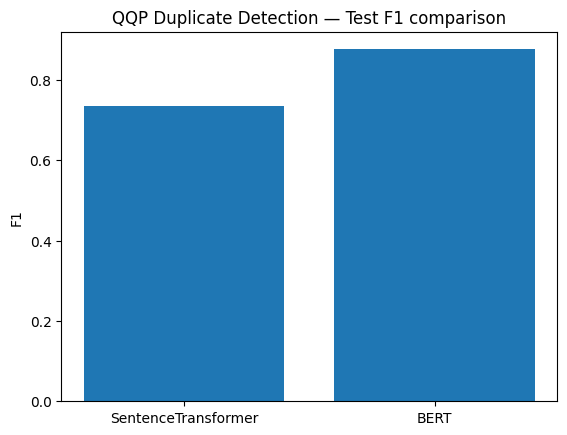

In [ ]:
compare = pd.DataFrame([
    {"model":"SentenceTransformer", **st_metrics},
    {"model":"BERT", **bert_metrics},
])

print(compare)

compare_path = os.path.join(RUN_DIR, "final_comparison.csv")
compare.to_csv(compare_path, index=False)
print("Saved:", compare_path)

plt.figure()
plt.bar(compare["model"], compare["f1"])
plt.title("QQP Duplicate Detection — Test F1 comparison")
plt.ylabel("F1")
plt.show()